<a href="https://colab.research.google.com/github/Ali-Asgar-Lakdawala/Book-Recommendation-System-capstone/blob/main/Book_Recommendation_System_Capstone.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# <b><u> Project Title : Book Recommendation System </u></b>

## Problem Description
During the last few decades, with the rise of Youtube, Amazon, Netflix, and many other such
web services, recommender systems have taken more and more place in our lives. From
e-commerce (suggest to buyers articles that could interest them) to online advertisement
(suggest to users the right contents, matching their preferences), recommender systems are
today unavoidable in our daily online journeys.
In a very general way, recommender systems are algorithms aimed at suggesting relevant
items to users (items being movies to watch, text to read, products to buy, or anything else
depending on industries).
Recommender systems are really critical in some industries as they can generate a huge
amount of income when they are efficient or also be a way to stand out significantly from
competitors. The main objective is to create a book recommendation system for users.



## Content

The Book-Crossing dataset comprises 3 files.
*  Users
Contains the users. Note that user IDs (User-ID) have been anonymized and map to
integers. Demographic data is provided (Location, Age) if available. Otherwise, these
fields contain NULL values.

*  Books
Books are identified by their respective ISBN. Invalid ISBNs have already been removed
from the dataset. Moreover, some content-based information is given (Book-Title,
Book-Author, Year-Of-Publication, Publisher), obtained from Amazon Web
Services. Note that in the case of several authors, only the first is provided. URLs linking
to cover images are also given, appearing in three different flavors (Image-URL-S,
Image-URL-M, Image-URL-L), i.e., small, medium, large. These URLs point to the
Amazon website.

*  Ratings
Contains the book rating information. Ratings (Book-Rating) are either explicit,
expressed on a scale from 1-10 (higher values denoting higher appreciation), or implicit,
expressed by 0

---
# importing
---

In [ ]:
#importing libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import scipy
from sklearn.preprocessing import normalize
from sklearn.metrics.pairwise import cosine_similarity
warnings.filterwarnings("ignore")
#to display all the graph in the workbook 
%matplotlib inline
sns.set_style("whitegrid",{'grid.linestyle': '--'})

In [ ]:
# Set the display figure size using rcParams method 
sns.set(rc={'figure.figsize':(8,6)})
plt.rcParams['figure.figsize'] = [8,6]

In [ ]:
# mounting google drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# setting up working directory path
woring_dir='/content/drive/MyDrive/Colab Notebooks/capstone unsup 1/data_book_recommendation/'

In [ ]:
# creating data frame from csv files
books_df=pd.read_csv(woring_dir + 'Books.csv')
users_df=pd.read_csv(woring_dir + 'Users.csv')
ratings_df=pd.read_csv(woring_dir + 'Ratings.csv')


In [ ]:
#checking for duplicate entries
print('duplicates in books = ',len(books_df)-len(books_df.drop_duplicates()))
print('duplicates in user = ',len(users_df)-len(users_df.drop_duplicates()))
print('duplicates in rating = ',len(ratings_df)-len(ratings_df.drop_duplicates()))

duplicates in books =  0
duplicates in user =  0
duplicates in rating =  0


---
# Dataset inspection & cleaning
---

## Books Data

In [ ]:
# extracting top 5 observations
books_df.head()

,ISBN,Book-Title,Book-Author,Year-Of-Publication,Publisher,Image-URL-S,Image-URL-M,Image-URL-L
0,0195153448,Classical Mythology,Mark P. O. Morford,2002,Oxford University Press,http://images.amazon.com/images/P/0195153448.0...,http://images.amazon.com/images/P/0195153448.0...,http://images.amazon.com/images/P/0195153448.0...
1,0002005018,Clara Callan,Richard Bruce Wright,2001,HarperFlamingo Canada,http://images.amazon.com/images/P/0002005018.0...,http://images.amazon.com/images/P/0002005018.0...,http://images.amazon.com/images/P/0002005018.0...
2,0060973129,Decision in Normandy,Carlo D'Este,1991,HarperPerennial,http://images.amazon.com/images/P/0060973129.0...,http://images.amazon.com/images/P/0060973129.0...,http://images.amazon.com/images/P/0060973129.0...
3,0374157065,Flu: The Story of the Great Influenza Pandemic...,Gina Bari Kolata,1999,Farrar Straus Giroux,http://images.amazon.com/images/P/0374157065.0...,http://images.amazon.com/images/P/0374157065.0...,http://images.amazon.com/images/P/0374157065.0...
4,0393045218,The Mummies of Urumchi,E. J. W. Barber,1999,W. W. Norton &amp; Company,http://images.amazon.com/images/P/0393045218.0...,http://images.amazon.com/images/P/0393045218.0...,http://images.amazon.com/images/P/0393045218.0...


In [ ]:
# Checking for null values
books_df.isnull().sum()

ISBN                   0
Book-Title             0
Book-Author            1
Year-Of-Publication    0
Publisher              2
Image-URL-S            0
Image-URL-M            0
Image-URL-L            3
dtype: int64

In [ ]:
## Drop duplicate rows
users_df.drop_duplicates(keep='last', inplace=True)
users_df.reset_index(drop=True, inplace=True)

In [ ]:
# droping the url columns 
books_df.drop(['Image-URL-S', 'Image-URL-M', 'Image-URL-L'], axis=1, inplace=True)
books_df.head()

,ISBN,Book-Title,Book-Author,Year-Of-Publication,Publisher
0,0195153448,Classical Mythology,Mark P. O. Morford,2002,Oxford University Press
1,0002005018,Clara Callan,Richard Bruce Wright,2001,HarperFlamingo Canada
2,0060973129,Decision in Normandy,Carlo D'Este,1991,HarperPerennial
3,0374157065,Flu: The Story of the Great Influenza Pandemic...,Gina Bari Kolata,1999,Farrar Straus Giroux
4,0393045218,The Mummies of Urumchi,E. J. W. Barber,1999,W. W. Norton &amp; Company


In [ ]:
books_df[books_df['Book-Author'].isnull()]

,ISBN,Book-Title,Book-Author,Year-Of-Publication,Publisher
187689,9627982032,The Credit Suisse Guide to Managing Your Perso...,NaN,1995,Edinburgh Financial Publishing


In [ ]:
books_df[books_df['Publisher'].isnull()]

,ISBN,Book-Title,Book-Author,Year-Of-Publication,Publisher
128890,193169656X,Tyrant Moon,Elaine Corvidae,2002,NaN
129037,1931696993,Finders Keepers,Linnea Sinclair,2001,NaN


In [ ]:
books_df['Book-Author'].fillna('Unknown',inplace=True)
books_df['Publisher'].fillna('Unknown',inplace=True)

In [ ]:
# Checking for null values
books_df.isnull().sum()

ISBN                   0
Book-Title             0
Book-Author            0
Year-Of-Publication    0
Publisher              0
dtype: int64

In [ ]:
books_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 271360 entries, 0 to 271359
Data columns (total 5 columns):
 #   Column               Non-Null Count   Dtype 
---  ------               --------------   ----- 
 0   ISBN                 271360 non-null  object
 1   Book-Title           271360 non-null  object
 2   Book-Author          271360 non-null  object
 3   Year-Of-Publication  271360 non-null  object
 4   Publisher            271360 non-null  object
dtypes: object(5)
memory usage: 10.4+ MB


year of publication should be an integer lets chek that 

In [ ]:
# Checking for column Year-of-publication
books_df['Year-Of-Publication'].unique()

array([2002, 2001, 1991, 1999, 2000, 1993, 1996, 1988, 2004, 1998, 1994,
       2003, 1997, 1983, 1979, 1995, 1982, 1985, 1992, 1986, 1978, 1980,
       1952, 1987, 1990, 1981, 1989, 1984, 0, 1968, 1961, 1958, 1974,
       1976, 1971, 1977, 1975, 1965, 1941, 1970, 1962, 1973, 1972, 1960,
       1966, 1920, 1956, 1959, 1953, 1951, 1942, 1963, 1964, 1969, 1954,
       1950, 1967, 2005, 1957, 1940, 1937, 1955, 1946, 1936, 1930, 2011,
       1925, 1948, 1943, 1947, 1945, 1923, 2020, 1939, 1926, 1938, 2030,
       1911, 1904, 1949, 1932, 1928, 1929, 1927, 1931, 1914, 2050, 1934,
       1910, 1933, 1902, 1924, 1921, 1900, 2038, 2026, 1944, 1917, 1901,
       2010, 1908, 1906, 1935, 1806, 2021, '2000', '1995', '1999', '2004',
       '2003', '1990', '1994', '1986', '1989', '2002', '1981', '1993',
       '1983', '1982', '1976', '1991', '1977', '1998', '1992', '1996',
       '0', '1997', '2001', '1974', '1968', '1987', '1984', '1988',
       '1963', '1956', '1970', '1985', '1978', '1973', '1980'

observation
* has two text values and one two zero and some books that have future date of publication

In [ ]:
books_df[books_df['Year-Of-Publication'] == '0']

,ISBN,Book-Title,Book-Author,Year-Of-Publication,Publisher
196656,3442035368,Ich Gestehe,Heinz G. Konsalik,0,Wilhelm Goldmann Verlag GmbH
196678,0553124803,Being There,Jerzy Kosinski,0,Bantam Doubleday Dell
196680,888274387X,Vaniglia E Cioccolato,Modignani Casati,0,Sperling Paperback
196685,033368155X,Surreal Lives the Surrealists 1945,Ruth Brandon,0,Humanity Press/prometheus Bk
196734,0207158452,Games of the Strong,Glenda Adams,0,Harpercollins Publisher
...,...,...,...,...,...
261929,0760700702,100 Great Archaeological Discoveries,Paul G Bahn,0,Barnes Noble Inc
261930,0760701962,UFO's: A Scientific Debate,Carl Sagan,0,Barnes Noble Books
261931,0760706379,Only Way to Cross,John Maxtone Graham,0,Barnes Noble
262120,0880292288,New York Times Guide to Reference Materials,Mona Mccormick,0,Dorset House Publishing Co Inc


In [ ]:
books_df[books_df['Year-Of-Publication'] == 'DK Publishing Inc']

,ISBN,Book-Title,Book-Author,Year-Of-Publication,Publisher
209538,078946697X,"DK Readers: Creating the X-Men, How It All Beg...",2000,DK Publishing Inc,http://images.amazon.com/images/P/078946697X.0...
221678,0789466953,"DK Readers: Creating the X-Men, How Comic Book...",2000,DK Publishing Inc,http://images.amazon.com/images/P/0789466953.0...


In [ ]:
books_df[books_df['Year-Of-Publication'] == 'Gallimard']

,ISBN,Book-Title,Book-Author,Year-Of-Publication,Publisher
220731,2070426769,"Peuple du ciel, suivi de 'Les Bergers\"";Jean-M...",2003,Gallimard,http://images.amazon.com/images/P/2070426769.0...


In [ ]:
list(books_df[(books_df['Year-Of-Publication'] == 'DK Publishing Inc')|( books_df['Year-Of-Publication'] == 'Gallimard')]['Book-Title'])

['DK Readers: Creating the X-Men, How It All Began (Level 4: Proficient Readers)\\";Michael Teitelbaum"',
 'Peuple du ciel, suivi de \'Les Bergers\\";Jean-Marie Gustave Le ClÃ?Â©zio"',
 'DK Readers: Creating the X-Men, How Comic Books Come to Life (Level 4: Proficient Readers)\\";James Buckley"']

In [ ]:
# replacing all suspicios data to relavent data 
books_df.at[209538 ,'Publisher'] = 'DK Publishing Inc'
books_df.at[209538 ,'Year-Of-Publication'] = 2000
books_df.at[209538 ,'Book-Title'] = 'DK Readers: Creating the X-Men, How It All Began (Level 4: Proficient Readers)'
books_df.at[209538 ,'Book-Author'] = 'Michael Teitelbaum'

books_df.at[221678 ,'Publisher'] = 'DK Publishing Inc'
books_df.at[221678 ,'Year-Of-Publication'] = 2000
books_df.at[209538 ,'Book-Title'] = 'DK Readers: Creating the X-Men, How Comic Boofksf Come to Life (Level 4: Proficient Readers)'
books_df.at[209538 ,'Book-Author'] = 'James Buckley'

books_df.at[220731 ,'Publisher'] = 'Gallimard'
books_df.at[220731 ,'Year-Of-Publication'] = 2003
books_df.at[209538 ,'Book-Title'] = 'Peuple du ciel - Suivi de Les bergers '
books_df.at[209538 ,'Book-Author'] = 'Jean-Marie Gustave Le ClÃ?Â©zio'

In [ ]:
# converting the data type
books_df['Year-Of-Publication'] = books_df['Year-Of-Publication'].astype(int)

In [ ]:
from datetime import date
# finding the current year
current_year = date.today().year
print(current_year)

2021


In [ ]:
# finding books with date of publication greater than cirrent date 
books_df.loc[(books_df['Year-Of-Publication'] > current_year)]

,ISBN,Book-Title,Book-Author,Year-Of-Publication,Publisher
37487,0671746103,MY TEACHER FRIED MY BRAINS (RACK SIZE) (MY TEA...,Coville,2030,Aladdin
55676,0671791990,MY TEACHER FLUNKED THE PLANET (RACK SIZE) (MY ...,Bruce Coville,2030,Aladdin
78168,0870449842,Crossing America,National Geographic Society,2030,National Geographic
80264,0140301690,Alice's Adventures in Wonderland and Through t...,Lewis Carroll,2050,Puffin Books
97826,0140201092,Outline of European Architecture (Pelican S.),Nikolaus Pevsner,2050,Penguin USA
116053,0394701658,Three Plays of Eugene Oneill,Eugene O'Neill,2038,Vintage Books USA
118294,3442436893,Das groÃ?Â?e BÃ?Â¶se- MÃ?Â¤dchen- Lesebuch.,Kathy Lette,2026,Goldmann
192993,0870446924,"Field Guide to the Birds of North America, 3rd...",National Geographic Society,2030,National Geographic
228173,0671266500,FOREST PEOPLE (Touchstone Books (Hardcover)),Colin M. Turnbull,2030,Simon &amp; Schuster
240169,0684718022,In Our Time: Stories (Scribner Classic),Ernest Hemingway,2030,Collier Books


In [ ]:
# replacing year of publication 0 and greater than 2021 to mean of the data set 
books_df.loc[(books_df['Year-Of-Publication'] > 2021) | (books_df['Year-Of-Publication'] == 0),'Year-Of-Publication'] = np.nan
books_df.fillna(round(books_df['Year-Of-Publication'].mean()),inplace=True)

In [ ]:
# Checking for column Year-of-publication
books_df['Year-Of-Publication'].describe()

count    271360.000000
mean       1993.693241
std           8.249980
min        1376.000000
25%        1989.000000
50%        1995.000000
75%        2000.000000
max        2021.000000
Name: Year-Of-Publication, dtype: float64

In [ ]:
books_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 271360 entries, 0 to 271359
Data columns (total 5 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   ISBN                 271360 non-null  object 
 1   Book-Title           271360 non-null  object 
 2   Book-Author          271360 non-null  object 
 3   Year-Of-Publication  271360 non-null  float64
 4   Publisher            271360 non-null  object 
dtypes: float64(1), object(4)
memory usage: 10.4+ MB


## User Data

In [ ]:
# extracting top 5 observations
users_df.head()

,User-ID,Location,Age
0,1,"nyc, new york, usa",NaN
1,2,"stockton, california, usa",18.0
2,3,"moscow, yukon territory, russia",NaN
3,4,"porto, v.n.gaia, portugal",17.0
4,5,"farnborough, hants, united kingdom",NaN


In [ ]:
users_df.shape

(278858, 3)

In [ ]:
# Checking null values
print(users_df.isna().sum())

User-ID          0
Location         0
Age         110762
dtype: int64


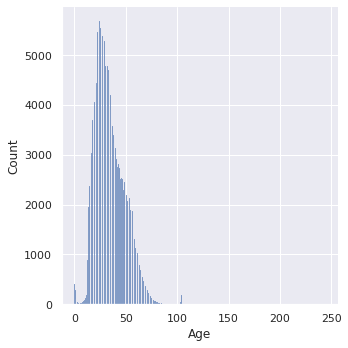

In [ ]:
sns.displot(users_df.Age)

* there are few people which are above 100 age which might be outliers 

## Ratings Data

In [ ]:
# extracting top 5 observations
ratings_df.head()

,User-ID,ISBN,Book-Rating
0,276725,034545104X,0
1,276726,0155061224,5
2,276727,0446520802,0
3,276729,052165615X,3
4,276729,0521795028,6


In [ ]:
# Checking for null values
ratings_df.isnull().sum()

User-ID        0
ISBN           0
Book-Rating    0
dtype: int64

In [ ]:
# combning all the data frames
df = pd.merge(books_df, ratings_df, on='ISBN', how='inner')
df = pd.merge(df, users_df, on='User-ID', how='inner')
df.head()

,ISBN,Book-Title,Book-Author,Year-Of-Publication,Publisher,User-ID,Book-Rating,Location,Age
0,0195153448,Classical Mythology,Mark P. O. Morford,2002.0,Oxford University Press,2,0,"stockton, california, usa",18.0
1,0002005018,Clara Callan,Richard Bruce Wright,2001.0,HarperFlamingo Canada,8,5,"timmins, ontario, canada",NaN
2,0060973129,Decision in Normandy,Carlo D'Este,1991.0,HarperPerennial,8,0,"timmins, ontario, canada",NaN
3,0374157065,Flu: The Story of the Great Influenza Pandemic...,Gina Bari Kolata,1999.0,Farrar Straus Giroux,8,0,"timmins, ontario, canada",NaN
4,0393045218,The Mummies of Urumchi,E. J. W. Barber,1999.0,W. W. Norton &amp; Company,8,0,"timmins, ontario, canada",NaN


In [ ]:
df['Location'].str.split(',', expand=True)[3].unique()

array([None, ' usa', ' united kingdom', ' philippines', ' france',
       'guishan li', ' canada', ' guam-dong', ' nigeria', ' indonesia',
       ' japan', ' georgia', ' spain', ' south korea', '', ' iceland',
       ' kansas', ' ireland', ' greece"', ' new zealand', ' malaysia',
       ' portugal', ' british columbia', ' italy', ' ontario', ' finland',
       ' singapore', ' germany', ' channel islands', ' tobago',
       ' austria', ' afghanistan', ' australia', ' deutschland',
       ' switzerland', ' mexico', ' galiza', ' c.a.', ' denmark',
       ' china', ' guam', ' cape verde', ' honduras', ' united states',
       'italy', ' disgruntled states of america', ' england', ' the',
       ' rhode island', ' netherlands', ' gifu', ' the world tomorrow'],
      dtype=object)

# Data Visualization

## Uni Variate Analysis

In [ ]:
df.head()

,ISBN,Book-Title,Book-Author,Year-Of-Publication,Publisher,User-ID,Book-Rating,Location,Age
0,0195153448,Classical Mythology,Mark P. O. Morford,2002.0,Oxford University Press,2,0,"stockton, california, usa",18.0
1,0002005018,Clara Callan,Richard Bruce Wright,2001.0,HarperFlamingo Canada,8,5,"timmins, ontario, canada",NaN
2,0060973129,Decision in Normandy,Carlo D'Este,1991.0,HarperPerennial,8,0,"timmins, ontario, canada",NaN
3,0374157065,Flu: The Story of the Great Influenza Pandemic...,Gina Bari Kolata,1999.0,Farrar Straus Giroux,8,0,"timmins, ontario, canada",NaN
4,0393045218,The Mummies of Urumchi,E. J. W. Barber,1999.0,W. W. Norton &amp; Company,8,0,"timmins, ontario, canada",NaN


Text(0.5, 1.0, 'Most read books(Top 15)')

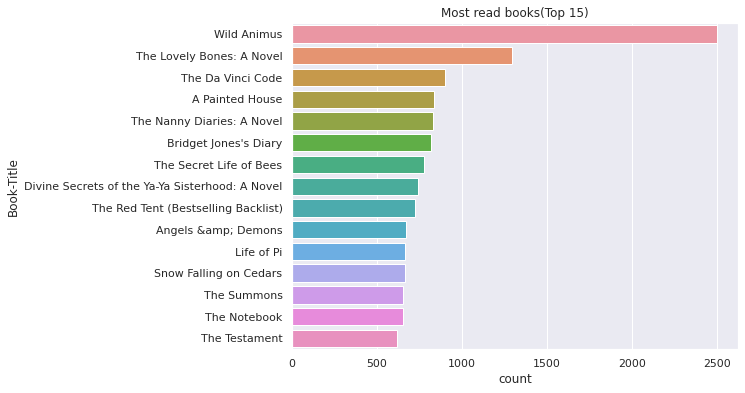

In [ ]:
sns.countplot(y="Book-Title", data=df, order=df['Book-Title'].value_counts().index[0:15])
plt.title("Most read books(Top 15)")

Observation

* We have 2,42,130 unique Book Title.
The top most book title found is Selected Poems.
Selected Poems is present in 27 rows in books data.

Text(0.5, 1.0, 'Autor with most no of books (Top 15)')

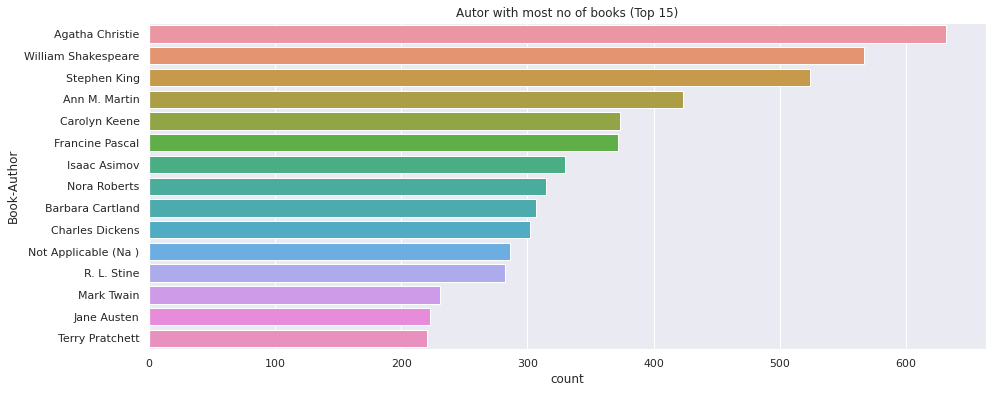

In [ ]:
plt.figure(figsize=(15,6))
sns.countplot(y="Book-Author", data=books_df,order=books_df['Book-Author'].value_counts().index[0:15])
plt.title("Autor with most no of books (Top 15)")

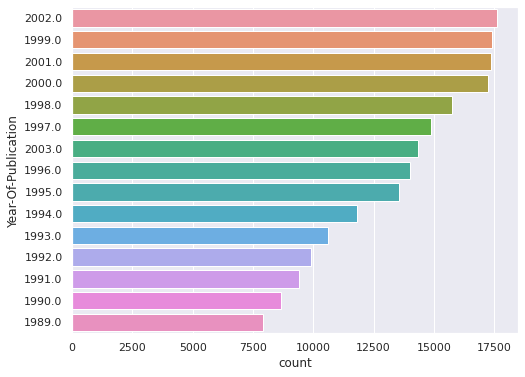

In [ ]:
sns.countplot(y="Year-Of-Publication", data=books_df,order=books_df['Year-Of-Publication'].value_counts().index[:15])

* most of the books are published between 1999 and 2002

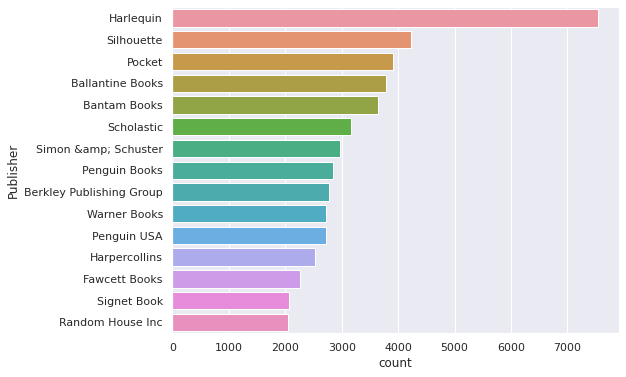

In [ ]:
sns.countplot(y="Publisher", data=books_df,order=books_df['Publisher'].value_counts().index[0:15])

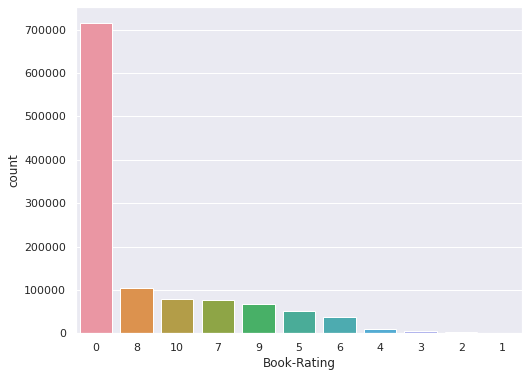

In [ ]:
sns.countplot(x="Book-Rating", data=ratings_df,order=ratings_df['Book-Rating'].value_counts().index[:])

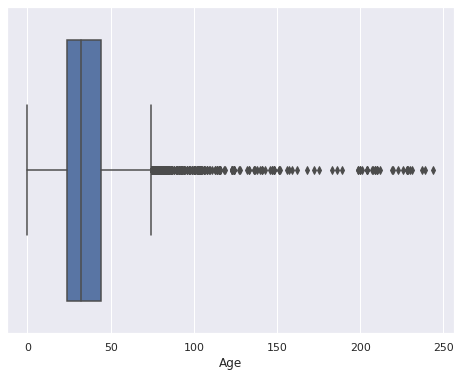

In [ ]:
# Checking the Outliers in Age.
sns.boxplot(users_df.Age)
plt.show()

In [ ]:
# First we are filling the nan value where the age is greater than 90 and less than 8 then replacing the nan with mean value.
users_df.loc[(users_df['Age'] > 100) | (users_df['Age'] < 5), 'Age']= np.NAN
users_df['Age']= users_df['Age'].fillna((users_df['Age'].mean()))

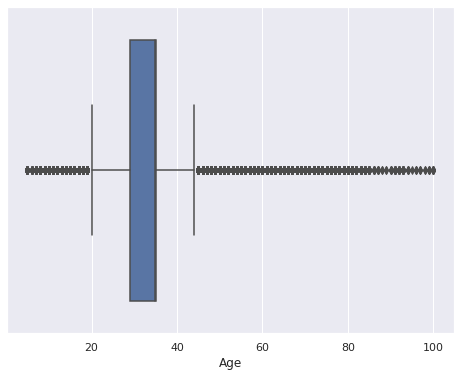

In [ ]:
sns.boxplot(users_df.Age)
plt.show()

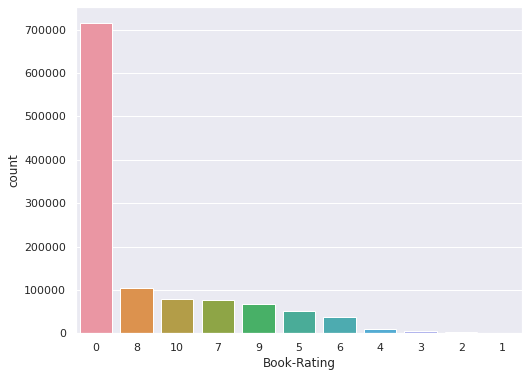

In [ ]:
plt.figure(figsize=(8,6))
sns.countplot(x="Book-Rating", data=ratings_df,order=ratings_df['Book-Rating'].value_counts().index[:])